# Project 2: Using machine learning to predict sale prices of residential property in Ames, Iowa
## Notebook 2:Modeling, feature elimination and evaluation

### Contents:
- [1. Modeling and Methodology](#1.-Modeling-and-Methodology)
- [2. Creating a simple baseline prediction $R^2$](#2.-Creating-a-simple-baseline-prediction-$R^2$)
- [3. Performing regressions on the processed EDA data](#3.-Performing-regressions-on-the-processed-EDA-data)
- [4. Using Lasso, Ridge and Elastic Net to select features](#4.-Using-Lasso,-Ridge-and-Elastic-Net-to-select-features)
- [5. Final reduction of features from 75 to 30](#5.-Final-reduction-of-features-from-75-to-30)
- [6. Predicting Sale Prices on the Kaggle Test Data](#6.-Predicting-Sale-Prices-on-the-Kaggle-Test-Data)


### Importing libraries and the dataset

In [1]:
# Importing the relevant libraries and data
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
from IPython.display import display

#import warnings
#warnings.filterwarnings('ignore')
df=pd.read_csv('../datasets/trainprocessed.csv')
df.head()

,lotarea,overallqual,overallcond,masvnrarea,exterqual,bsmtqual,totalbsmtsf,grlivarea,totrmsabvgrd,fireplaces,...,exterior_MetalSd,exterior_Plywood,exterior_Stone,exterior_Stucco,exterior_VinylSd,exterior_Wd Sdng,exterior_Wd Shng,exterior_WdShing,lotareasq,grlivareasq
0,13517,6,8,289.0,4,3,725.0,1479,6,0,...,0,1,0,0,0,0,0,0,13519,1477
1,11492,7,5,132.0,4,4,913.0,2122,8,1,...,0,0,0,0,1,0,0,0,11494,2120
2,7922,5,7,0.0,3,3,1057.0,1057,5,0,...,0,0,0,0,1,0,0,0,7920,1059
3,9802,5,5,0.0,3,4,384.0,1444,7,0,...,0,0,0,0,1,0,0,0,9800,1446
4,14235,6,8,0.0,3,2,676.0,1445,6,0,...,0,1,0,0,0,1,0,0,14233,1447


In [2]:
plt.style.use('seaborn')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFECV, RFE
from sklearn.dummy import DummyRegressor
import patsy

***
# 1. Modeling and Methodology

### Setting X and y variables, splitting into training and validation sets and performing scaling

To produce the predictions, 4 regression models were used to evaluate the training data:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net Regression

The data was processed in the following steps: 

The data was run through each regression type to produce coefficients
The coefficients were sorted in order of magnitude of effect
Features were eliminated until 75 remained
A further round of regression and ordering by coefficients was performed
Features were eliminated until 30 remained
These features were used to predict sale prices in the Kaggle test data set

In [4]:
target = [i for i in df.select_dtypes('number').columns if i != 'saleprice']
X = df[target]
y = df['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [5]:
# For use later on in narrowing down features based on model outputs
def setandscale(resultpd, targetmodel, data=df): 
    target = resultpd[targetmodel].tolist()
    X = data[target]
    y = data['saleprice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    ss=StandardScaler()
    ss.fit(X_train)
    X_train_scaled = ss.transform(X_train)
    X_test_scaled = ss.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X

### 1.1 Defining visualisation functions

In [6]:
# Heatmap function to help check for multicollinearity
def hotzones(data, columnfilter, titlename, colormap = "coolwarm", figuresize = (15,15)):
    datamask = np.zeros_like(data[columnfilter].corr())
    datamask[np.triu_indices_from(datamask)] = True
    plt.figure(figsize = figuresize)
    plt.title(titlename)
    sns.heatmap(final[columnfilter].corr(), mask=datamask, square=True, annot=True, cmap=colormap)

In [7]:
def coefplot(data, feature, coefficient, titlename = '', colormap = 'Reds_d'):
    sns.barplot(data=data, x=coefficient, y=feature, palette=colormap)
    plt.title(titlename)


In [8]:
def residual_prediction_plot(y_train, y_train_pred, y_test, y_test_pred, figuresize = (14,7)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figuresize)
    # Residual Scatter
    ax1.scatter(y_train_pred, (y_train_pred - y_train), c='orange', label='Training data')
    ax1.scatter(y_test_pred, (y_test_pred - y_test), c='blue', label='Validation data')
    ax1.set_title('Residuals')
    ax1.set_xlabel('Predicted Value')
    ax1.set_ylabel('Residual')
    ax1.legend(loc='upper left')
    ax1.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='black', linestyle='dashed')
    
    # Predictions Scatter
    ax2.scatter(y_train_pred, y_train, c='orange', label='Training data')
    ax2.scatter(y_test_pred, y_test, c='blue', label='Validation data')
    ax2.set_title('Predictions')
    ax2.set_xlabel('Predicted Value')
    ax2.set_ylabel('Actual Value')
    ax2.legend(loc='upper left')
    ax2.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='dashed')
    plt.tight_layout()

In [9]:
def coefsort(ridge,lasso,elastic,featcount):
    ridgesorted = ridge.sort_values('abs_ridge_coef',ascending=False)[['ridge_feature', 'abs_ridge_coef']].head(featcount).reset_index(drop=True)
    lassosorted = lasso.sort_values('abs_lasso_coef',ascending=False)[['lasso_feature', 'abs_lasso_coef']].head(featcount).reset_index(drop=True)
    enetsorted = elastic.sort_values('abs_enet_coef',ascending=False)[['enet_feature', 'abs_enet_coef']].head(featcount).reset_index(drop=True)
    sorted = pd.DataFrame()
    sorted = pd.concat([ridgesorted,lassosorted,enetsorted],axis=1)
    return sorted


### 1.2 Defining functions to perform the regressions

In [10]:
# Linear regression which will received scaled independent variables
def linreg(X_train, X_test, y_train, y_test):
    lr = LinearRegression()   
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
        
    training_r2 = lr.score(X_train, y_train) 
    training_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    testing_r2 = lr.score(X_test, y_test) 
    testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))    
      
    # 5-fold cross validation score
    cv_r2_score = cross_val_score(lr, X_train, y_train, cv=5).mean()
    cv_mse_score = -cross_val_score(lr, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error').mean()
    
    print('========')  
    print('Linear Regression Results \n')
    print('Training R2: ', round(training_r2,3))
    print('Validation R2: ',round(testing_r2,3))
    print('Cross validation mean R2: ', round(cv_r2_score,3))
    print('')
    print('Training RMSE: ', round(training_rmse,3))
    print('Validation RMSE: ', round(testing_rmse,3))
    print('Cross validation mean RMSE: ', round(np.sqrt(cv_mse_score),3))
    print('========')    
    
    residual_prediction_plot(y_train, y_train_pred, y_test, y_test_pred)

In [11]:
# Ridge regression which will received scaled independent variables
def ridgereg(X_train, X_test, y_train, y_test):
    r_alphas = np.logspace(0, 5, 200)
    rr = RidgeCV(alphas=r_alphas, cv=5)
    rr.fit(X_train, y_train)
    
    optimal_alpha = rr.alpha_    
    
    # take optimal alpha from CV search and create a new model with the optimal alpha and fit on the
    # entire train dataset
    optimal_ridge = Ridge(alpha=optimal_alpha, random_state=42)
    
    optimal_ridge.fit(X_train,y_train)
    y_test_pred = optimal_ridge.predict(X_test)
    y_train_pred = optimal_ridge.predict(X_train)

    training_r2 = optimal_ridge.score(X_train, y_train) 
    training_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    testing_r2 = optimal_ridge.score(X_test, y_test)
    testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    optimal_ridge_mean_r2 = cross_val_score(optimal_ridge, X_train, y_train, cv=5).mean() # R2
    optimal_ridge_cv_mean_mse = np.sqrt(np.abs((-cross_val_score(optimal_ridge, X_train, y_train, cv=5, 
                                                  scoring='neg_mean_squared_error')).mean()))
                
    print('========')  
    print('Ridge Regression Results \n')
    print('Optimal alpha: ', round(optimal_alpha,5))
    print('Training R2: ', round(training_r2,3))
    print('Validation R2: ',round(testing_r2,3))
    print('Cross validation mean R2: ', round(optimal_ridge_mean_r2,3))
    print('')
    print('Training RMSE: ', round(training_rmse,3))
    print('Validation RMSE: ', round(testing_rmse,3))
    print('Cross validation mean RMSE: ', round(optimal_ridge_cv_mean_mse),3)
    print('========')    
    
    # Coefficients
    coef_df = pd.DataFrame({'ridge_feature': X.columns,
                 'ridge_coef': optimal_ridge.coef_,
                 'abs_ridge_coef': np.abs(optimal_ridge.coef_)}).sort_values('abs_ridge_coef', ascending=False) 
    
    residual_prediction_plot(y_train, y_train_pred, y_test, y_test_pred)
    return coef_df

In [12]:
# Lasso regression which will received scaled independent variables
def lassoreg(X_train, X_test, y_train, y_test):
    lasso_model = LassoCV(n_alphas=100, cv=5, random_state=42)   
    lasso_model.fit(X_train, y_train)
    
    optimal_alpha = lasso_model.alpha_
    
    optimal_lasso = Lasso(alpha=optimal_alpha, max_iter=10000, random_state=42)
    optimal_lasso.fit(X_train, y_train)
    y_test_pred = optimal_lasso.predict(X_test)
    y_train_pred = optimal_lasso.predict(X_train)    
    
    training_r2 = optimal_lasso.score(X_train, y_train) 
    training_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    testing_r2 = optimal_lasso.score(X_test, y_test)
    testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    optimal_lasso_mean_r2 = cross_val_score(optimal_lasso, X_train, y_train, cv=5).mean() # R2
    optimal_lasso_cv_mean_mse = np.abs((-cross_val_score(optimal_lasso, X_train, y_train, cv=5, 
                                                  scoring='neg_mean_squared_error')).mean())    
    
    print('========')  
    print('Lasso Regression Results \n')
    print('Optimal alpha: ', round(optimal_alpha,5),'\n')
    print('Training R2: ', round(training_r2,3))
    print('Validation R2: ',round(testing_r2,3))
    print('Cross validation mean R2: ', round(optimal_lasso_mean_r2,3),'\n')
    print('Training RMSE: ', round(training_rmse,3))
    print('Validation RMSE: ', round(testing_rmse,3))
    print('Cross validation mean RMSE: ', round(np.sqrt(optimal_lasso_cv_mean_mse),3))
    print('========')    
    
    coef_df = pd.DataFrame({'lasso_feature': X.columns,
                 'lasso_coef': optimal_lasso.coef_,
                 'abs_lasso_coef': np.abs(optimal_lasso.coef_)}).sort_values('abs_lasso_coef', ascending=False)    
    
    residual_prediction_plot(y_train, y_train_pred, y_test, y_test_pred)
    return coef_df

In [13]:
# Elastic Net regression which will received scaled independent variables
def elasticnet(X_train, X_test, y_train, y_test):
    enet_model = ElasticNetCV(n_alphas=100, l1_ratio=np.linspace(0.01, 1.0, 25), cv=5, random_state=42)
    enet_model = enet_model.fit(X_train, y_train)

    optimal_alpha = enet_model.alpha_
    optimal_l1ratio = enet_model.l1_ratio_
    # If l1_ratio = 1, the penalty would be L1 penalty. If l1_ratio = 0, the penalty would be an L2 penalty. 
    # If the value of l1 ratio is between 0 and 1, the penalty would be the combination of L1 and L2.
      
    optimal_enet = ElasticNet(alpha = optimal_alpha, l1_ratio = optimal_l1ratio, max_iter=10000)
    optimal_enet.fit(X_train, y_train)
    
    # generate predictions for both test and train data
    y_test_pred = optimal_enet.predict(X_test)
    y_train_pred = optimal_enet.predict(X_train)    
    
    training_r2 = optimal_enet.score(X_train, y_train) 
    training_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # evaluate the model using validation data
    testing_r2 = optimal_enet.score(X_test, y_test)
    testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    optimal_enet_mean_r2 = cross_val_score(optimal_enet, X_train, y_train, cv=5).mean() # R2
    optimal_enet_cv_mean_mse = np.abs((-cross_val_score(optimal_enet, X_train, y_train, cv=5, 
                                                  scoring='neg_mean_squared_error')).mean())      

    print('========')  
    print('Elastic Net Regression Results \n')
    print('Optimal alpha: ', round(optimal_alpha,5),'\n')    
    print('Training R2: ', round(training_r2,3))
    print('Validation R2: ',round(testing_r2,3))
    print('Cross validation mean R2: ', round(optimal_enet_mean_r2,3),'\n')
    print('Training RMSE: ', round(training_rmse,3))
    print('Validation RMSE: ', round(testing_rmse,3))
    print('Cross validation mean RMSE: ', round(np.sqrt(optimal_enet_cv_mean_mse),3))
    print('========')    
    
    
    # Coefficients
    coef_df = pd.DataFrame({'enet_feature': X.columns,
                 'enet_coef': optimal_enet.coef_,
                 'abs_enet_coef': np.abs(optimal_enet.coef_)}).sort_values('abs_enet_coef', ascending=False)    
    
    residual_prediction_plot(y_train, y_train_pred, y_test, y_test_pred)
    return coef_df

***
# 2. Creating a simple baseline prediction $R^2$

Using sklearn's DummyRegressor function, a simple prediction of $\hat{y} = $$\bar{y} $ is produced using our training data, providing the minimum $R^2$ and mean square error that our models must exceed.

In [14]:
dummyreg = DummyRegressor(strategy = 'mean')
dummyreg.fit(X_train_scaled,y_train)
dummyreg.score(X_test_scaled, y_test)

-0.009460525092726213

An $R^2$ of -0.009 shows that a simple regression is highly imprecise, and does not explain much of the variability of the dependent variable, saleprice.

***
# 3. Performing regressions on the processed EDA data



Linear Regression Results 

Training R2:  0.896
Validation R2:  0.877
Cross validation mean R2:  -2.3365844046488547e+25

Training RMSE:  26107.359
Validation RMSE:  25657.55
Cross validation mean RMSE:  3.799661344232786e+17


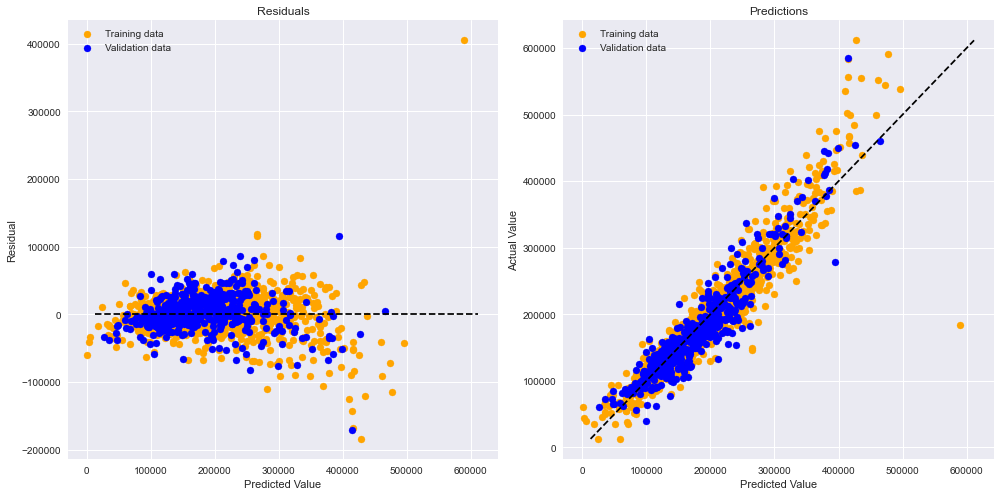

In [15]:
linreg(X_train_scaled, X_test_scaled, y_train, y_test)

Ridge Regression Results 

Optimal alpha:  307.2113
Training R2:  0.892
Validation R2:  0.875
Cross validation mean R2:  0.849

Training RMSE:  26703.388
Validation RMSE:  25873.962
Cross validation mean RMSE:  31708 3


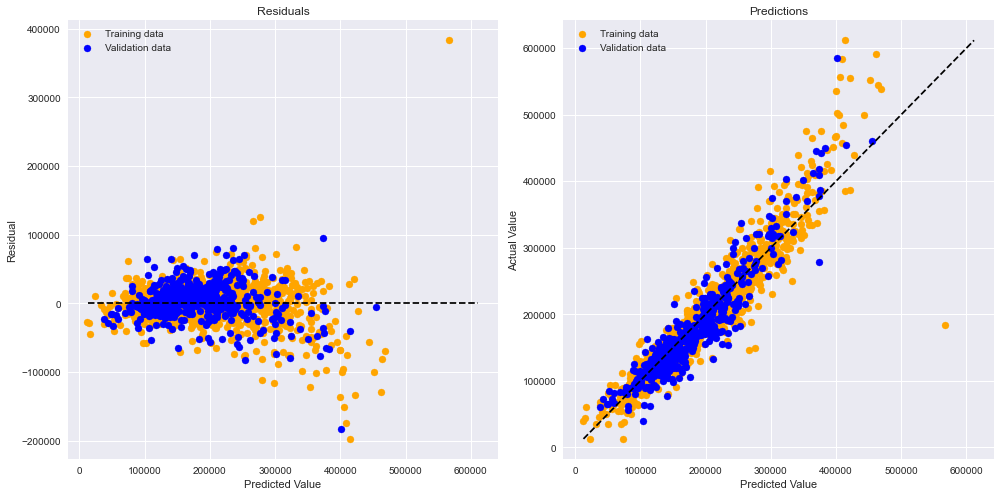

In [16]:
ridge1 = ridgereg(X_train_scaled, X_test_scaled, y_train, y_test)


Lasso Regression Results 

Optimal alpha:  431.08529 

Training R2:  0.893
Validation R2:  0.879
Cross validation mean R2:  0.845 

Training RMSE:  26576.903
Validation RMSE:  25450.806
Cross validation mean RMSE:  32134.646


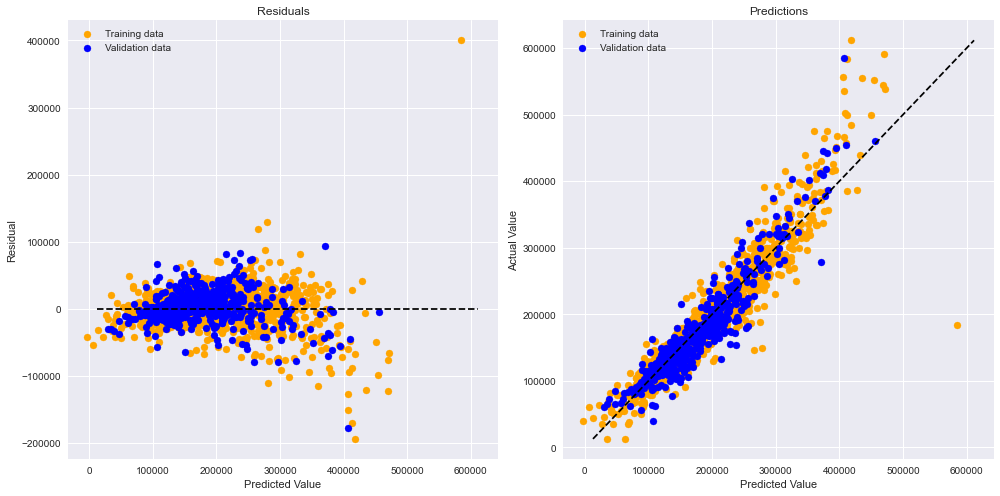

In [17]:
lasso1 = lassoreg(X_train_scaled, X_test_scaled, y_train, y_test)

Elastic Net Regression Results 

Optimal alpha:  431.08529 

Training R2:  0.893
Validation R2:  0.879
Cross validation mean R2:  0.845 

Training RMSE:  26576.903
Validation RMSE:  25450.806
Cross validation mean RMSE:  32134.646


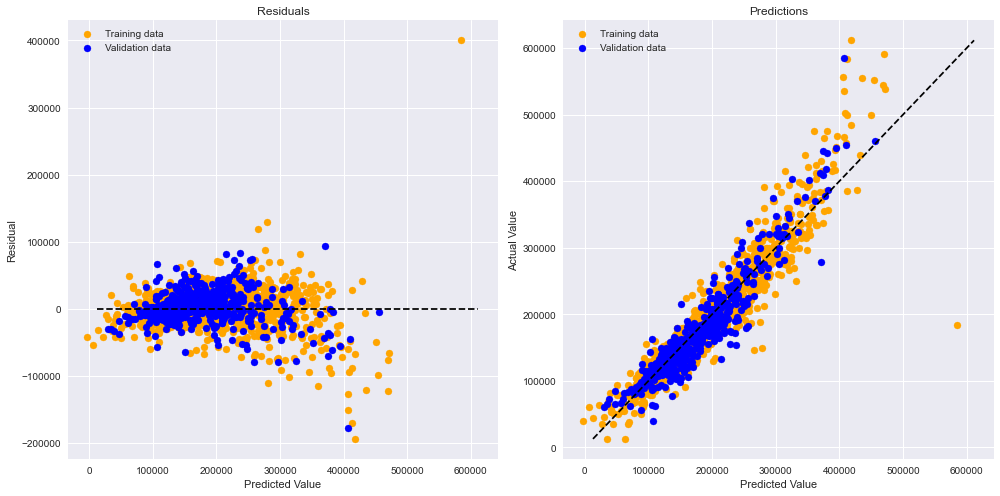

In [18]:
elastic1 = elasticnet(X_train_scaled, X_test_scaled, y_train, y_test)

##### Observations: Lasso and Enet produced the same output, which was only slightly higher than ridge in RMSE

# 4. Using Lasso, Ridge and Elastic Net to select features

From the original 151 features, we will select 75 features (half of our original) based on the size of their coefficients in absolute value to the corresponding standardised independent variables. The 75 largest absolute coefficients based on each model will be selected, and then re-run through each of the 3 regression model types.

From each of these sets of feature inputs and models, we will compare the RMSE of each output to determine if there is a preferable feature set and model upon which to further reduce the model count.

In [19]:
coefs75 = coefsort(ridge1,lasso1,elastic1,75)
coefs75

,ridge_feature,abs_ridge_coef,lasso_feature,abs_lasso_coef,enet_feature,abs_enet_coef
0,overallqual,10363.315955,grlivarea,20211.947969,grlivarea,20211.947969
1,roofmatl_ClyTile,9211.658151,overallqual,13306.041244,overallqual,13306.041244
2,grlivareasq,8469.278171,roofmatl_ClyTile,11870.683028,roofmatl_ClyTile,11870.683028
3,grlivarea,8457.587446,neighborhood_NridgHt,9228.275302,neighborhood_NridgHt,9228.275302
4,exterqual,7917.920754,exterqual,9043.173500,exterqual,9043.173500
...,...,...,...,...,...,...
70,neighborhood_SWISU,920.686915,neighborhood_OldTown,451.829214,neighborhood_OldTown,451.829214
71,bsmtexposure_None,899.328591,neighborhood_SWISU,445.346421,neighborhood_SWISU,445.346421
72,masvnrtype_BrkFace,883.389334,roofmatl_Tar&Grv,411.546741,roofmatl_Tar&Grv,411.546741
73,neighborhood_Blueste,880.732387,neighborhood_NAmes,394.052870,neighborhood_NAmes,394.052870


## 4.1 Testing using Ridge's Initial Selection of features

In [20]:
X_train_scaled, X_test_scaled, y_train, y_test, X = setandscale(coefs75, 'ridge_feature')

Ridge Regression Results 

Optimal alpha:  289.94229
Training R2:  0.89
Validation R2:  0.876
Cross validation mean R2:  0.854

Training RMSE:  26938.48
Validation RMSE:  25723.011
Cross validation mean RMSE:  31207 3


,ridge_feature,ridge_coef,abs_ridge_coef
0,overallqual,10411.482344,10411.482344
1,roofmatl_ClyTile,-9569.584775,9569.584775
2,grlivareasq,8542.706507,8542.706507
3,grlivarea,8528.983774,8528.983774
4,exterqual,8071.833429,8071.833429
...,...,...,...
67,housestyle_SLvl,-855.211779,855.211779
69,neighborhood_Crawfor,814.366244,814.366244
73,neighborhood_Blueste,-730.018815,730.018815
65,condition_RRAn,-686.226002,686.226002


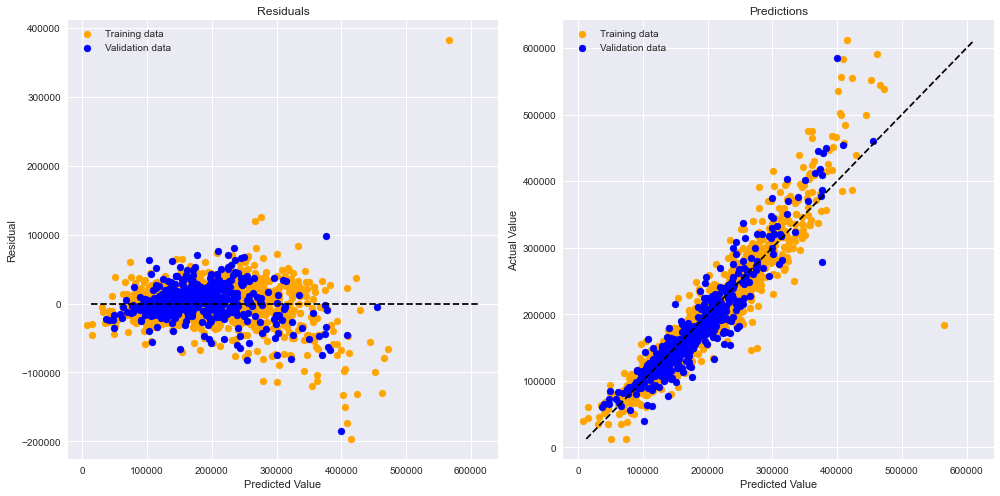

In [21]:
ridgereg(X_train_scaled, X_test_scaled, y_train, y_test)

Lasso Regression Results 

Optimal alpha:  246.68285 

Training R2:  0.892
Validation R2:  0.879
Cross validation mean R2:  0.848 

Training RMSE:  26615.682
Validation RMSE:  25391.887
Cross validation mean RMSE:  31774.284


,lasso_feature,lasso_coef,abs_lasso_coef
2,grlivareasq,20721.128857,20721.128857
0,overallqual,12469.296620,12469.296620
1,roofmatl_ClyTile,-12092.391628,12092.391628
6,neighborhood_NridgHt,8790.109986,8790.109986
4,exterqual,8644.181553,8644.181553
...,...,...,...
41,roofstyle_Gable,-0.000000,0.000000
3,grlivarea,0.000000,0.000000
59,foundation_CBlock,-0.000000,0.000000
22,lotarea,0.000000,0.000000


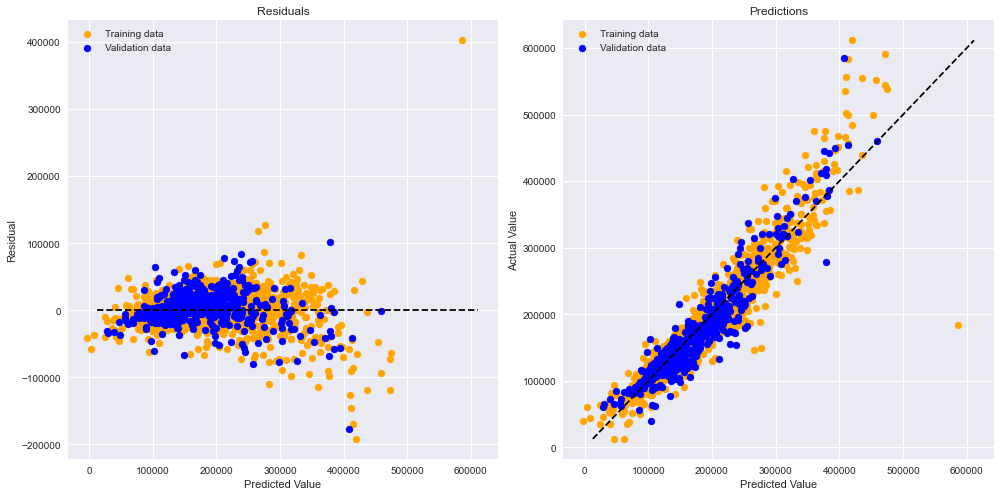

In [22]:
lassoreg(X_train_scaled, X_test_scaled, y_train, y_test)

Elastic Net Regression Results 

Optimal alpha:  246.68285 

Training R2:  0.892
Validation R2:  0.879
Cross validation mean R2:  0.848 

Training RMSE:  26615.682
Validation RMSE:  25391.887
Cross validation mean RMSE:  31774.284


,enet_feature,enet_coef,abs_enet_coef
2,grlivareasq,20721.128857,20721.128857
0,overallqual,12469.296620,12469.296620
1,roofmatl_ClyTile,-12092.391628,12092.391628
6,neighborhood_NridgHt,8790.109986,8790.109986
4,exterqual,8644.181553,8644.181553
...,...,...,...
41,roofstyle_Gable,-0.000000,0.000000
3,grlivarea,0.000000,0.000000
59,foundation_CBlock,-0.000000,0.000000
22,lotarea,0.000000,0.000000


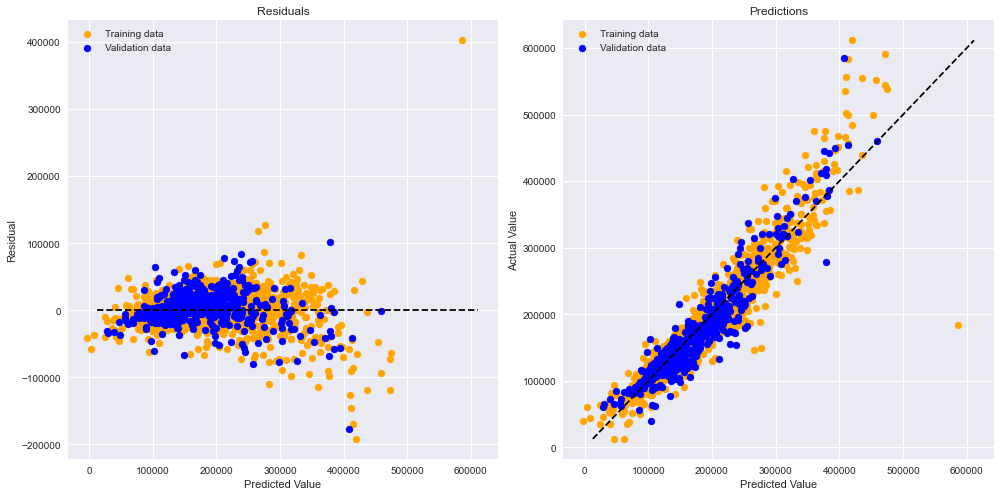

In [23]:
elasticnet(X_train_scaled, X_test_scaled, y_train, y_test)

##### Observations:
The RMSE of the ridge regression was only slightly lower than Enet and Lasso, which both produced the same Mean Square error.

## 4.2 Testing using Lasso's Initial Selection of features

In [24]:
X_train_scaled, X_test_scaled, y_train, y_test, X = setandscale(coefs75, 'lasso_feature')

Ridge Regression Results 

Optimal alpha:  273.644
Training R2:  0.891
Validation R2:  0.876
Cross validation mean R2:  0.854

Training RMSE:  26806.287
Validation RMSE:  25735.943
Cross validation mean RMSE:  31161 3


,ridge_feature,ridge_coef,abs_ridge_coef
1,overallqual,10646.745315,10646.745315
2,roofmatl_ClyTile,-9747.084212,9747.084212
42,grlivareasq,9032.615241,9032.615241
0,grlivarea,9018.826696,9018.826696
4,exterqual,8193.505629,8193.505629
...,...,...,...
67,newatsale,-651.182512,651.182512
65,neighborhood_Greens,-639.155922,639.155922
63,neighborhood_CollgCr,629.449840,629.449840
68,exterior_BrkComm,-609.729622,609.729622


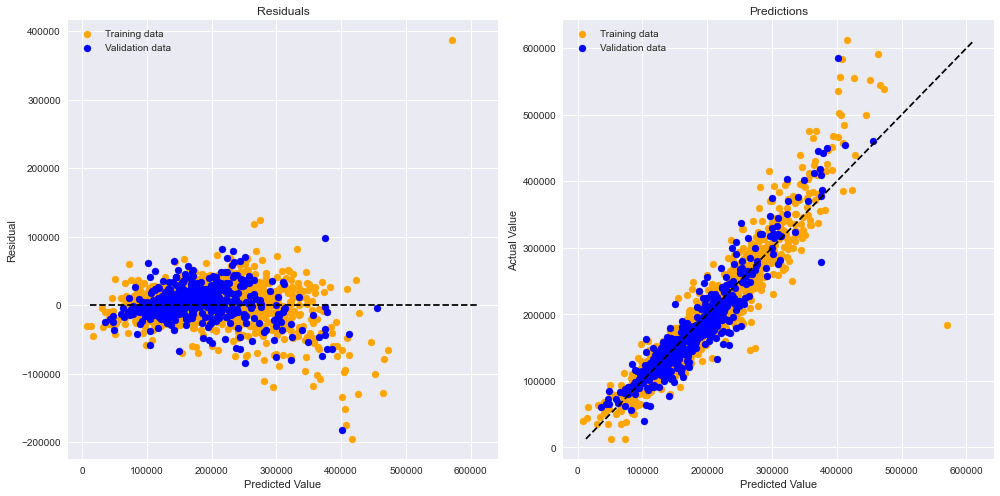

In [25]:
ridgereg(X_train_scaled, X_test_scaled, y_train, y_test)

Lasso Regression Results 

Optimal alpha:  141.161 

Training R2:  0.893
Validation R2:  0.877
Cross validation mean R2:  0.849 

Training RMSE:  26465.467
Validation RMSE:  25601.274
Cross validation mean RMSE:  31665.755


,lasso_feature,lasso_coef,abs_lasso_coef
42,grlivareasq,21104.747865,21104.747865
1,overallqual,12201.294623,12201.294623
2,roofmatl_ClyTile,-12095.323290,12095.323290
3,neighborhood_NridgHt,9615.442016,9615.442016
4,exterqual,8508.161710,8508.161710
...,...,...,...
68,exterior_BrkComm,-725.332201,725.332201
71,neighborhood_SWISU,-723.665402,723.665402
72,roofmatl_Tar&Grv,-653.834199,653.834199
70,neighborhood_OldTown,-558.868443,558.868443


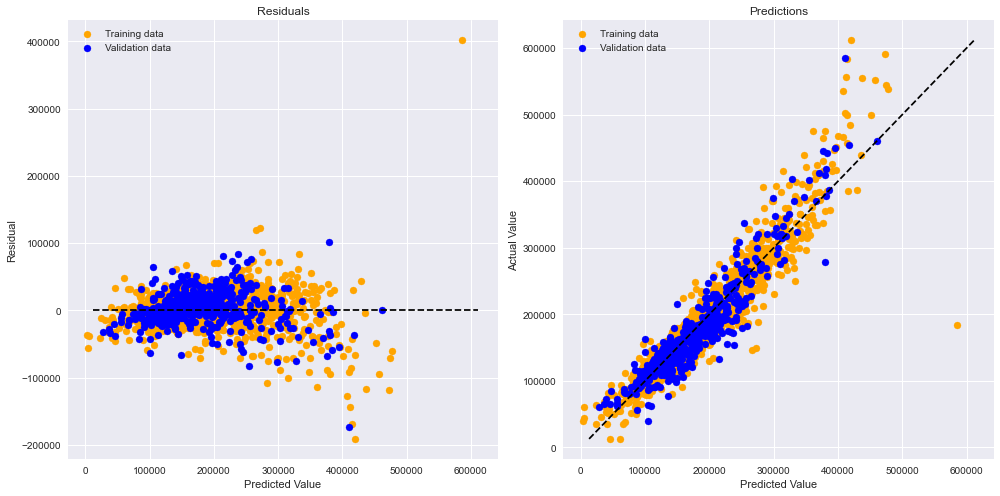

In [26]:
lassoreg(X_train_scaled, X_test_scaled, y_train, y_test)

Elastic Net Regression Results 

Optimal alpha:  141.161 

Training R2:  0.893
Validation R2:  0.877
Cross validation mean R2:  0.849 

Training RMSE:  26465.467
Validation RMSE:  25601.274
Cross validation mean RMSE:  31665.755


,enet_feature,enet_coef,abs_enet_coef
42,grlivareasq,21104.747865,21104.747865
1,overallqual,12201.294623,12201.294623
2,roofmatl_ClyTile,-12095.323290,12095.323290
3,neighborhood_NridgHt,9615.442016,9615.442016
4,exterqual,8508.161710,8508.161710
...,...,...,...
68,exterior_BrkComm,-725.332201,725.332201
71,neighborhood_SWISU,-723.665402,723.665402
72,roofmatl_Tar&Grv,-653.834199,653.834199
70,neighborhood_OldTown,-558.868443,558.868443


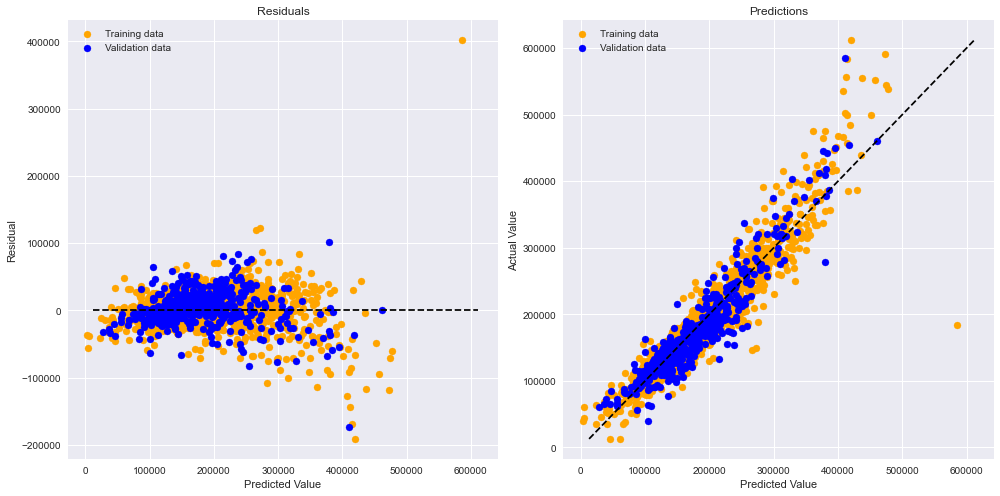

In [27]:
elasticnet(X_train_scaled, X_test_scaled, y_train, y_test)

##### Observations:
The RMSE of the ridge regression was only slightly lower than Enet and Lasso, which both produced the same Mean Square error.

## 4.3 Testing using Enet's Initial Selection of features

In [28]:
X_train_scaled, X_test_scaled, y_train, y_test, X = setandscale(coefs75, 'enet_feature')

The RMSE of the ridge regression was only slightly lower than Enet and Lasso, which both produced the same Mean Square error.

Ridge Regression Results 

Optimal alpha:  273.644
Training R2:  0.891
Validation R2:  0.876
Cross validation mean R2:  0.854

Training RMSE:  26806.287
Validation RMSE:  25735.943
Cross validation mean RMSE:  31161 3


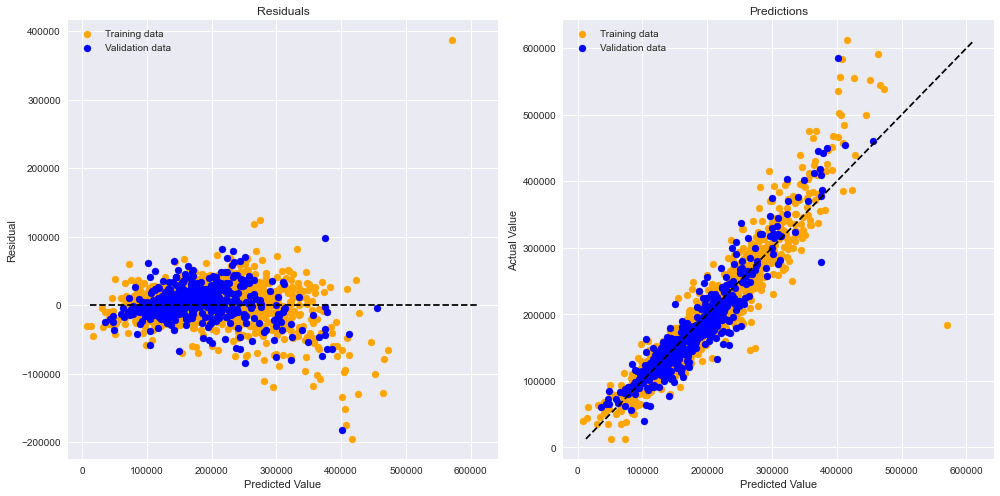

In [29]:
ridge2=ridgereg(X_train_scaled, X_test_scaled, y_train, y_test)

Lasso Regression Results 

Optimal alpha:  141.161 

Training R2:  0.893
Validation R2:  0.877
Cross validation mean R2:  0.849 

Training RMSE:  26465.467
Validation RMSE:  25601.274
Cross validation mean RMSE:  31665.755


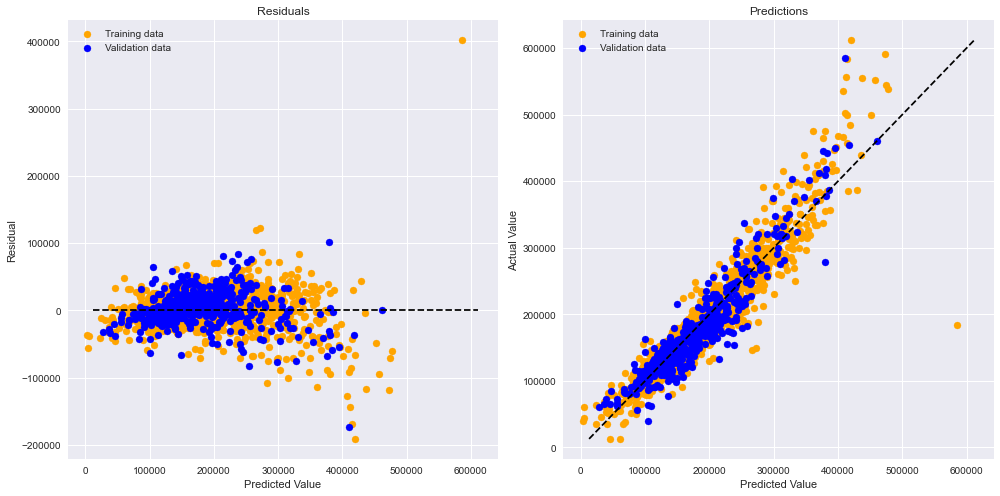

In [30]:
lasso2=lassoreg(X_train_scaled, X_test_scaled, y_train, y_test)

Elastic Net Regression Results 

Optimal alpha:  141.161 

Training R2:  0.893
Validation R2:  0.877
Cross validation mean R2:  0.849 

Training RMSE:  26465.467
Validation RMSE:  25601.274
Cross validation mean RMSE:  31665.755


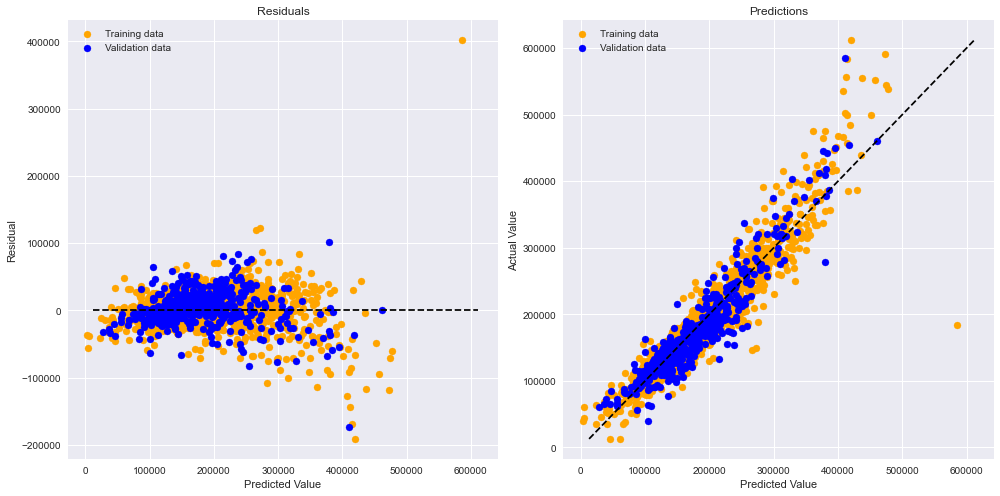

In [31]:
elastic2=elasticnet(X_train_scaled, X_test_scaled, y_train, y_test)

##### Observations:
The RMSE of the ridge regression was only slightly lower than Enet and Lasso, which both produced the same Mean Square error.

***
# 5. Final reduction of features from 75 to 30

Lasso and Enet produced the same RMSE on their own outputs.

For the purposes of the final selection, we will use Enet's data from 4.3 to produce the final list of 30 coefficients. The top 30 coefficients in absolute magnitude were ranked in the table below, as produced by their respective regression models.

In [32]:
coefs30 = coefsort(ridge2,lasso2,elastic2,30)
coefs30

,ridge_feature,abs_ridge_coef,lasso_feature,abs_lasso_coef,enet_feature,abs_enet_coef
0,overallqual,10646.745315,grlivareasq,21104.747865,grlivareasq,21104.747865
1,roofmatl_ClyTile,9747.084212,overallqual,12201.294623,overallqual,12201.294623
2,grlivareasq,9032.615241,roofmatl_ClyTile,12095.323290,roofmatl_ClyTile,12095.323290
3,grlivarea,9018.826696,neighborhood_NridgHt,9615.442016,neighborhood_NridgHt,9615.442016
4,exterqual,8193.505629,exterqual,8508.161710,exterqual,8508.161710
5,neighborhood_NridgHt,8124.116872,garagearea,7699.221540,garagearea,7699.221540
6,garagearea,7480.343100,totalbsmtsf,7125.172614,totalbsmtsf,7125.172614
7,totalbsmtsf,6545.257487,neighborhood_StoneBr,7107.296450,neighborhood_StoneBr,7107.296450
8,neighborhood_StoneBr,6230.769052,overallcond,6542.039990,overallcond,6542.039990
9,bsmtqual,5413.057786,bsmtqual,6185.139758,bsmtqual,6185.139758


In [33]:
X_train_scaled, X_test_scaled, y_train, y_test, X = setandscale(coefs30, 'enet_feature')

Linear Regression Results 

Training R2:  0.882
Validation R2:  0.865
Cross validation mean R2:  0.842

Training RMSE:  27862.867
Validation RMSE:  26835.928
Cross validation mean RMSE:  32327.126


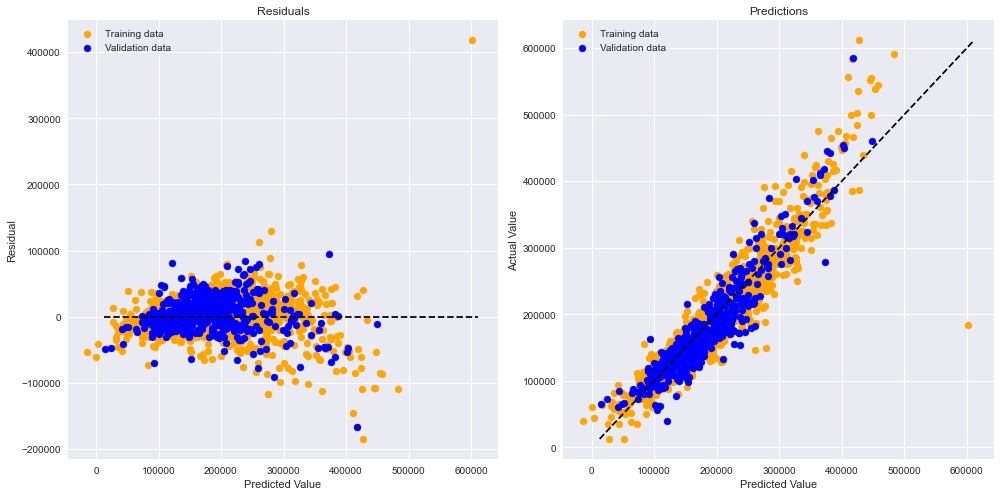

In [34]:
linreg(X_train_scaled, X_test_scaled, y_train, y_test)

Elastic Net Regression Results 

Optimal alpha:  200.09207 

Training R2:  0.882
Validation R2:  0.866
Cross validation mean R2:  0.844 

Training RMSE:  27879.987
Validation RMSE:  26779.711
Cross validation mean RMSE:  32145.697


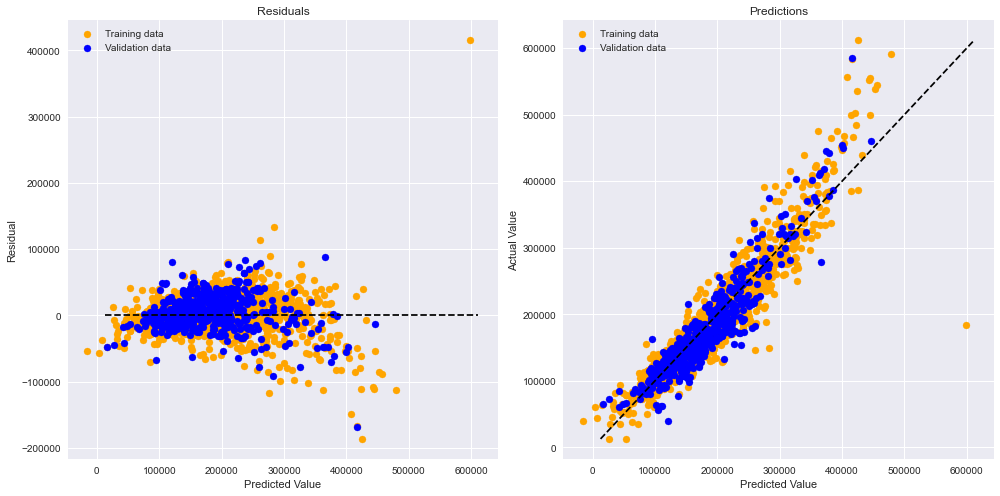

In [35]:
elasticfinal=elasticnet(X_train_scaled, X_test_scaled, y_train, y_test)

The final 30 selected features are displayed below, ordered in decreasing magnitude.

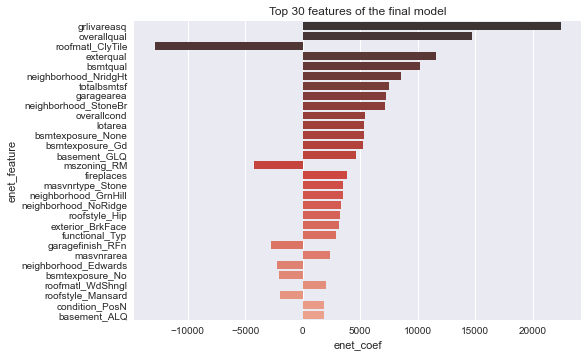

In [36]:
coefplot(elasticfinal,'enet_feature', 'enet_coef', titlename = 'Top 30 features of the final model')

#### Final Observations:

Disappointly, overall RMSE did not decrease significantly despite having a more focused set of features.

***
# 6. Predicting Sale Prices on the Kaggle Test Data 
Using the top 30 values from the Enet regression, we will attempt to predict housing price data based on provided variables from the test data set.

In [37]:
testdf=pd.read_csv('../datasets/test.csv')
df=pd.read_csv('../datasets/trainprocessed.csv')

In [38]:
testdf.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


### 6.1 Perform necessary transformations on Test Data
All transformations that were performed on the initial train dataset are performed on the test dataset.

In [39]:
# Convert the column names to lower case and drop spaces
testdf.columns = testdf.columns.str.replace(' ','')
testdf.rename(str.lower, axis=1, inplace=True)

In [40]:
# Imputing the missing values with either none or 0
def autofiller(data):
    data.fillna(0, inplace=True)
    for col in data.columns:
        if data[col].dtypes == 'object':
            data[col].replace({0:'None'},inplace=True)
        else:
            pass
    return data     
autofiller(testdf)
testdf.head()

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,...,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,None,None,None,0,4,2006,WD
1,2718,905108090,90,RL,0.0,9662,Pave,None,IR1,Lvl,...,0,0,0,None,None,None,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,None,IR1,Lvl,...,0,0,0,None,None,None,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,None,Reg,Lvl,...,0,0,0,None,None,None,0,7,2007,WD
4,625,535105100,20,RL,0.0,9500,Pave,None,IR1,Lvl,...,0,185,0,None,None,None,0,7,2009,WD


In [41]:
# Convert the ordinal columns to numerical columns
ordinalcolumns = ['exterqual','extercond','bsmtqual','bsmtcond','heatingqc','kitchenqual','garagequal','garagecond']
for col in ordinalcolumns:
        testdf[col] = testdf[col].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

In [42]:
# A mask for the used categorical variables
usefulcat = ['mszoning','street','landcontour','neighborhood','housestyle',
                   'roofstyle','roofmatl','masvnrtype','foundation','bsmtexposure',
                   'functional', 'fireplacequ', 'garagetype','garagefinish']

In [43]:
# Feature engineering of categorical variables
def twopartdummies(column1, column2, data, prefix = ''):
    dum = data[column1].str.get_dummies().add(data[column2].str.get_dummies(),fill_value=0)
    for col in dum.columns:
        dum[col] = dum[col].map({2:1, 1:1,0:0}, na_action='ignore')
    dum = dum.astype(int).add_prefix(prefix)
    return dum   


In [44]:
# Combining two part categories and creating dummies
testdf = pd.concat([testdf,twopartdummies('bsmtfintype1', 'bsmtfintype2', testdf, prefix = 'basement_')],axis=1)
testdf = pd.concat([testdf,twopartdummies('exterior1st', 'exterior2nd', testdf, prefix = 'exterior_')],axis=1)
testdf = pd.concat([testdf,twopartdummies('condition1', 'condition2', testdf, prefix = 'condition_')],axis=1)

In [45]:
testdf = pd.get_dummies(testdf)

In [46]:
# Create polynomial variable
testdf['grlivareasq'] = testdf['grlivarea']^2

In [47]:
# Create the train and test sets
initialtarget = coefs30['enet_feature'].tolist()
target = [i for i in initialtarget if i in testdf.columns.tolist()]
X_final = df[target]
y_final = df['saleprice']
X_testfinal = testdf[target]
ss=StandardScaler()
ss.fit(X_final)
X_final_scaled = ss.transform(X_final)
X_testfinal_scaled = ss.transform(X_testfinal)

It should be noted that two dummy elements in the set of 30, **'roofmatl_ClyTile'** and **'neighborhood_GrnHill'**, were not present in the test dataset, and excluded from the final regression.

In [48]:
print([i for i in initialtarget if i not in testdf.columns.tolist()])

['roofmatl_ClyTile', 'neighborhood_GrnHill']


In [49]:
def ridgetest(X_train, X_test, y_train, testdata):
    r_alphas = np.logspace(0, 5, 200)
    rr = RidgeCV(alphas=r_alphas, cv=5)
    rr.fit(X_train, y_train)
    
    optimal_alpha = rr.alpha_        
    # take optimal alpha from CV search and create a new model with the optimal alpha and fit on the
    # entire train dataset
    optimal_ridge = Ridge(alpha=optimal_alpha, random_state=42)
    
    optimal_ridge.fit(X_train,y_train)
    y_test_pred = optimal_ridge.predict(X_test)
    testprediction = pd.concat([testdata[['id']], pd.DataFrame(y_test_pred,columns=['saleprice'])], axis=1)
    return testprediction

In [50]:
def lassotest(X_train, X_test, y_train, testdata):
    lasso_model = LassoCV(n_alphas=100, cv=5, random_state=42)   
    lasso_model.fit(X_train, y_train)
    
    optimal_alpha = lasso_model.alpha_
    
    optimal_lasso = Lasso(alpha=optimal_alpha, max_iter=10000, random_state=42)
    optimal_lasso.fit(X_train, y_train)
    y_test_pred = optimal_lasso.predict(X_test)  
    
    testprediction = pd.concat([testdata[['id']], pd.DataFrame(y_test_pred,columns=['saleprice'])], axis=1)
    return testprediction

In [51]:
def elastictest(X_train, X_test, y_train, testdata):
    enet_model = ElasticNetCV(n_alphas=100, l1_ratio=np.linspace(0.01, 1.0, 25), cv=5, random_state=42)
    enet_model = enet_model.fit(X_train, y_train)

    optimal_alpha = enet_model.alpha_
    optimal_l1ratio = enet_model.l1_ratio_
    # If l1_ratio = 1, the penalty would be L1 penalty. If l1_ratio = 0, the penalty would be an L2 penalty. 
    # If the value of l1 ratio is between 0 and 1, the penalty would be the combination of L1 and L2.
      
    optimal_enet = ElasticNet(alpha = optimal_alpha, l1_ratio = optimal_l1ratio, max_iter=10000)
    optimal_enet.fit(X_train, y_train)
    y_test_pred = optimal_enet.predict(X_test) 
    testprediction = pd.concat([testdata[['id']], pd.DataFrame(y_test_pred,columns=['saleprice'])], axis=1)
    return testprediction

### 6.2 Creating the final product
The results put in dataframes and exported for submission on Kaggle

In [52]:
result1 = ridgetest(X_final_scaled, X_testfinal_scaled, y_final, testdf)
result2 = lassotest(X_final_scaled, X_testfinal_scaled, y_final, testdf)
result3 = elastictest(X_final_scaled, X_testfinal_scaled, y_final, testdf)

In [53]:
# Renaming the columns to the required format 
result1.rename(columns={'id':'Id','saleprice':'SalePrice'},inplace=True)
result2.rename(columns={'id':'Id','saleprice':'SalePrice'},inplace=True)
result3.rename(columns={'id':'Id','saleprice':'SalePrice'},inplace=True)

In [54]:
# Exporting the final datasets
result1.to_csv('../datasets/kaggleridgesubmission.csv', index=False)
result2.to_csv('../datasets/kagglelassosubmission.csv', index=False)
result3.to_csv('../datasets/kagglenetsubmission.csv', index=False)

#### Kaggle Scores
The Kaggle score of each submission was approximately 32k, matching previous observations in the second stage of regression where the RMSE of each model was very similar (and Kaggle scores are granted based on RMSE of predictions).

***
# 7. Final comments

### Conclusion

The models produced unfortunately had very large residuals, indicating that the method of estimation is imprecise and any prediction had a large confidence interval. The outputs produced may be useful for taking a rough stab at initial estimation of house prices, however as noted in 'Modeling Home Price Using Realtor Data" by Pardoe, expert opinion still plays a significant factor in giving reasonable estimates of house prices. More accurate predictions are not possible without a significant improvement in experiment design and a narrowing of the problem statement, which we shall discuss below.

As for the used experimental model, 'none' categorical variables should have been omitted during dummy encoding. One such example is bsmtexposure : none, which shows up in the final model.

##### Limitations in the data
Limited predictive power outside of the geographical constraint and time period

In general, housing price data reflects the local nature of housing markets and results are not applicable outside of the metropolitan area it is investigating.

The data's time collection frame also happens to include the 2007 to 2008 financial crisis, which was in part precipitated by the bursting of an American housing price bubble. Any houses sold in this period may well be explained by extraordinary circumstances such as foreclosures or otherwise homeowner bankruptancy, resulting in severely depressed housing prices. Blind application of these results outside of the time period may result in wildly undervalued housing sale value predictions.

##### Limitations in experiment design
Instead of blindly trying to regress on large, unconstrained set of features and then picking the ones that stood out the most, there may be much more analytical value in controlling for certain subsets of features and seeing how certain treatments such as different roofing or external house coverings explain variability in prices. 

It did occur that certain selected features used in the final model were not present in the unseen data. This reflects the inability of the model to generalise on unseen features and that it also loses explanatory power if features included in the model are not present. One potential fix is not to attempt to estimate house prices as a whole, but instead investigate the treatment effect of universal house metrics on sale prices, while attempting to hold other features constant.

##### Limitations in experiment methodology
Firstly, additional features could have been used, such as polynomialising all the independent variables, or checking for interaction effects. For example, values such as basement exposure which appear in the final model may have little to no explanatory power

The data could have also been regressed on log sales prices, which may have increased explanatory power if the true effect of housing characteristics on sale price is exponential. 

Secondly, as noted by David Pasta in "Learning When to be Discrete", there are measures that can be taken to counteract the loss of explanatory power when applying a continuous scale to ordinal variables with uncertain distance between categories.
